In [1]:
import torch

print(torch.cuda.is_available())

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'


print('Selected device:', device)

True
Selected device: cuda


In [2]:
import pandas as pd

''' Load Tokens from CSV '''
df = pd.read_parquet('../data-sets/train-00000-of-00001 - 2025-11-01.parquet')


df

,ENG_TOKENS,NLD_TOKENS
0,"[<sos>, It, 's, for, you, ., <eos>]","[<sos>, Het, is, voor, jou, ., <eos>]"
1,"[<sos>, You, know, ,, I, ..., <eos>]","[<sos>, Weet, je, ,, ik, ...., <eos>]"
2,"[<sos>, You, knew, ?, <eos>]","[<sos>, Je, wist, het, ?, <eos>]"
3,"[<sos>, -, Do, n't, try, and, talk, anymore, ....","[<sos>, Stil, maar, ., <eos>]"
4,"[<sos>, -, I, am, your, friend, ., <eos>]","[<sos>, -, Dat, ben, ik, ook, ., Pap, ., <eos>]"
...,...,...
999995,"[<sos>, It, 's, a, giant, portrait, of, them, ...","[<sos>, een, groot, portret, van, ze, van, cho..."
999996,"[<sos>, I, do, n't, know, what, to, say, ., <e...","[<sos>, Ik, ben, sprakeloos, ., <eos>]"
999997,"[<sos>, In, this, case, ,, a, corrective, amou...","[<sos>, In, dat, geval, kan, op, de, restituti..."
999998,"[<sos>, Everything, looks, fine, ,, Jillian, ....","[<sos>, Alles, ziet, er, goed, uit, ,, Jillian..."


In [3]:
TRAIN_SPLIT = 0.9
MAX_SIZE = 20
FORBIDDEN_CHARS = ['€', '$', '[', ']', '-']

''' Filtering '''
def filter(row):	
	if (len(row['ENG_TOKENS']) > 20):
		return False
    
	if (len(row['NLD_TOKENS']) > 20):
		return False
	
	if any(fc in token for fc in ['€', '$', '[', ']', '-'] for token in " ".join(row['ENG_TOKENS']) + " ".join(row['NLD_TOKENS'])):
		return False

	return True

df = df[df.apply(filter, axis=1)]

''' Splitting Training and Validation Data '''
df = df.sample(frac=1).reset_index(drop=True)
split = int(TRAIN_SPLIT * len(df))

train_data = df.iloc[:split, :]
test_data  = df.iloc[split:, :]
test_data.reset_index(drop=True, inplace=True)


print('Total rows from file:', len(df))
print('Total rows of train data:', len(train_data))
train_data

Total rows from file: 662319
Total rows of train data: 596087


,ENG_TOKENS,NLD_TOKENS
0,"[<sos>, Barley, <eos>]","[<sos>, Gerst, <eos>]"
1,"[<sos>, You, know, something, ?, We, are, all,...","[<sos>, Weet, je, ,, we, zijn, hier, allemaal,..."
2,"[<sos>, Just, animals, ., <eos>]","[<sos>, Alleen, dieren, ., <eos>]"
3,"[<sos>, I, just, met, her, ., '', <eos>]","[<sos>, ik, heb, haar, pas, net, ontmoet, ., '..."
4,"[<sos>, No, ,, no, ,, no, ., <eos>]","[<sos>, Nee, ., <eos>]"
...,...,...
596082,"[<sos>, We, must, change, the, sugar, market, ...","[<sos>, Wij, moeten, de, suikermarkt, verander..."
596083,"[<sos>, Everybody, thinks, it, 's, just, kid, ...","[<sos>, Iedereen, denkt, dat, het, alleen, ......"
596084,"[<sos>, OJ, L, 325, ,, 24.11.2006, ,, p., 12, ...","[<sos>, PB, L, 325, van, 24.11.2006, ,, blz., ..."
596085,"[<sos>, Yeah, ,, I, get, it, ., <eos>]","[<sos>, Ja, ,, ik, begrijp, het, ., <eos>]"


In [4]:
PAD_token = '<pad>'
SOS_token = '<sos>'
EOS_token = '<eos>'
UNK_token = '<unk>'

min_size = 10

class Vocabulary():

	def __init__(self):
		self.num_tokens = 0
		self.token2index = {}
		self.index2token = {}
		self.token2count = {}
		
		for token in [PAD_token, SOS_token, EOS_token, UNK_token]:
			self.add_token(token)

	def add_token(self, token):
		if token not in self.token2index:
			ix = self.num_tokens

			self.token2index[token] = ix
			self.index2token[ix] = token
			self.token2count[token] = 1
			self.num_tokens += 1
		else:
			self.token2count[token] += 1
	
	def limit(self):
		valid_tokens = [
			t for t, c in self.token2count.items()
			if c >= min_size or t in [PAD_token, SOS_token, EOS_token, UNK_token]
		]

		self.token2index.clear()
		self.index2token.clear()
		self.num_tokens = 0
		
		for token in [PAD_token, SOS_token, EOS_token, UNK_token]:
			self.token2index[token] = self.num_tokens
			self.index2token[self.num_tokens] = token
			self.num_tokens += 1

		for token in valid_tokens:
			if token not in self.token2index:
				self.token2index[token] = self.num_tokens
				self.index2token[self.num_tokens] = token
				self.num_tokens += 1

		self.token2count = {t: self.token2count[t] for t in valid_tokens}
	
	def lookup_indices(self, tokens):
		return [self[token] for token in tokens]
	
	def lookup_tokens(self, indices):
		return [self.index2token.get(ix, UNK_token) for ix in indices]

	def __len__(self):
		return self.num_tokens

	def __getitem__(self, key):
		return self.token2index.get(key, self.token2index[UNK_token])

	@staticmethod
	def from_dataframe(df, column):
		vocab = Vocabulary()
		for tokens in df[column]:
			for token in tokens.tolist():
				vocab.add_token(token)
		
		vocab.limit()
		return vocab


eng_vocab = Vocabulary.from_dataframe(train_data, "ENG_TOKENS")
nld_vocab = Vocabulary.from_dataframe(train_data, 'NLD_TOKENS')

print('size of english vocab:', len(eng_vocab))
print('size of dutch vocat:', len(nld_vocab))

sorted(eng_vocab.token2count.items(), key=lambda x: x[1], reverse=True)[:20]

size of english vocab: 15409
size of dutch vocat: 15791


[('<sos>', 596088),
 ('<eos>', 596088),
 ('.', 442242),
 (',', 205893),
 ('I', 134247),
 ('the', 110752),
 ('you', 106613),
 ('?', 105097),
 ('to', 86887),
 ("'s", 71630),
 ('a', 68473),
 ('of', 51486),
 ("n't", 45534),
 ('it', 45450),
 ('is', 41758),
 ('!', 39051),
 ('that', 39012),
 ('You', 38225),
 ('in', 37843),
 ('and', 34435)]

In [5]:
import numpy as np

eng_pad_index = eng_vocab[PAD_token]
nld_pad_index = nld_vocab[PAD_token]

''' Vectorize the data '''
def build_dataset(subset):
    X = np.zeros((len(subset), MAX_SIZE), dtype=np.int32)
    Y = np.zeros((len(subset), MAX_SIZE), dtype=np.int32)
        
    for ix, row in subset.iterrows():
        eng_ixs = eng_vocab.lookup_indices(row['ENG_TOKENS'])
        eng_ixs = eng_ixs + [eng_pad_index] * (MAX_SIZE - len(eng_ixs))

        nld_ixs = nld_vocab.lookup_indices(row['NLD_TOKENS'])
        nld_ixs = nld_ixs + [nld_pad_index] * (MAX_SIZE - len(nld_ixs))

        X[ix] = eng_ixs
        Y[ix] = nld_ixs

    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)

    return X, Y


Xtr, Ytr = build_dataset(train_data)
Xte, Yte = build_dataset(test_data)


import random

print('Xtr shape:', Xtr.shape)

Xtr shape: torch.Size([596087, 20])


In [6]:
print('Random vector:')
ix = random.randint(0, len(Xtr))
print(Xtr[ix].tolist())
print(Ytr[ix].tolist())
print()
print(eng_vocab.lookup_tokens(Xtr[ix].tolist()))
print(nld_vocab.lookup_tokens(Ytr[ix].tolist()))

Random vector:
[1, 62, 18, 46, 50, 64, 11, 41, 881, 15, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 242, 134, 293, 67, 3038, 66, 16, 188, 841, 9, 196, 1032, 13, 2, 0, 0, 0, 0, 0]

['<sos>', 'And', 'I', 'meant', 'to', 'be', 'here', 'that', 'long', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<sos>', 'Het', 'was', 'ook', 'de', 'bedoeling', 'dat', 'ik', 'zo', 'lang', 'hier', 'zou', 'blijven', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
### Bidirection Encoder ###

class Encoder(nn.Module):

    def __init__(self, vocab_size, emb_dim, hidden_size, num_layers=1):
        super(Encoder, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers  = num_layers

        self.embeddings  = nn.Embedding(vocab_size, emb_dim)
        self.rnn         = nn.GRU(emb_dim, hidden_size, num_layers, batch_first=True, bidirectional=True)

    def forward(self, input):
        ''' The input of the encoder is a matrix of vectorized tokens in a shape of batch size * sequence length '''
        # input = [N, L]

        batch_size = input.shape[0] # N

        ''' Get learnable multi-dimensional embeddings of the input matrix '''
        embeddings = self.embeddings(input)
        # embeddings = [N, L, embedding dim]

        ''' Run the embeddings through an RNN, iterating over the `sequence length` dimension '''
        output, hidden = self.rnn(embeddings)
        # output = [N, L, 2 * hidden size]
        # hidden = [2 * num layers, N, hidden size]

        '''  Concat hidden states of forward and backward passes to obtain the annotations '''
        hidden = hidden.view(self.num_layers, 2, batch_size, self.hidden_size) # [num layers, 2, N, hidden size]
        hidden = torch.cat((hidden[:, 0, :, :], hidden[:, 1, :, :]), dim=2)    # [num layers, N, 2 * hidden size]

        '''
         * Encoder outputs: Sequence of (the sum of) hidden states from the encoder for each time step.
         * Hidden state:    The last hidden state from the encoder, which can be used to initialize the decoder's hidden state.
        '''
        return output, hidden


In [9]:
### Bahdanau Attention mechanism ###

''' The attention determines which part of the input (encodings) is relevant for the current decoder's hidden state '''

class Attention(nn.Module):

    def __init__(self, num_layers, hidden_size):
        super(Attention, self).__init__()

        self.W1 = nn.Linear(num_layers * hidden_size, hidden_size)
        self.W2 = nn.Linear(2*hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, 1, bias=False)

    
    def forward(self, hidden, encodings):
        ''' The decoder's hidden state is also known as the 'Query', and the encoder's outputs as the 'Values' '''
        # hidden    = [num layers, N, hidden size]
        # encodings = [N, L, 2 * hidden size]

        hidden = torch.movedim(hidden, 0, 1)
        # hidden = [N, num layers, hidden size]

        batch_size =  hidden.shape[0] # N
        num_layers =  hidden.shape[1]
        hidden_size = hidden.shape[2]

        concat_hidden = hidden.reshape(batch_size, num_layers * hidden_size)
        # concat_hidden = [N, num layers * hidden size]

        concat_hidden = concat_hidden.unsqueeze(1) # add a dimension to match the encodings
        # concat_hidden = [N, 1, num layers * hidden size]

        ''' Calculate scores '''
        scores = self.V(torch.tanh(self.W1(concat_hidden) + self.W2(encodings)))
        # scores = [N, L, 1]

        scores = torch.movedim(scores, 1, 2)
        # scores = [N, 1, L]

        ''' Rescale so that the scores lie in the range of [0-1] and sum to 1. '''
        attention_weights = F.softmax(scores, dim=-1)
        # attention_weights = [N, 1, L]

        ''' Calculate the context vector '''
        context_vector = torch.bmm(attention_weights, encodings)
        # context_vector = [N, 1, 2 * hidden size]

        context_vector = context_vector.squeeze(1)
        attention_weights = attention_weights.squeeze(1)
        # context_vector = [N, 2 * hidden size]
        # attention_weights = [N, L]

        return  context_vector, attention_weights

In [10]:
### Decoder ###

class Decoder(nn.Module):
    
    def __init__(self, vocab_size, emb_dim, hidden_size, num_layers=1):
        super(Decoder, self).__init__()

        self.vocab_size  = vocab_size
        self.hidden_size = hidden_size

        self.attention   = Attention(num_layers, hidden_size)
        self.embeddings  = nn.Embedding(vocab_size, emb_dim)
        self.rnn         = nn.GRU(emb_dim + hidden_size*2, hidden_size, num_layers, batch_first=True)
        self.fc          = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, input, hidden, encodings):
        # input     = [N]
        # hidden    = [num layers, N, hidden size]
        # encodings = [N, L, 2 * hidden size]

        ''' Get learnable multi-dimensional embeddings of the input '''
        embeddings = self.embeddings(input)
        # embeddings = [N, embedding dim]

        ''' Recompute context vector every time step, using the hidden state of the last RNN layer and the encoder outputs '''
        context_vector, att_weights = self.attention(hidden, encodings)
        # context_vector = [N, hidden size * 2]
        # att_weights    = [N, L]

        ''' Join the embeddings with the context vector as input for the decoder RNN '''
        rnn_input = torch.cat((embeddings, context_vector), dim=1)
        # rnn_input = [N, embedding dim + 2 * hidden size]

        rnn_input = rnn_input.unsqueeze(1) # Add a single `sequence length` dimension
        # rnn_input = [N, 1, embedding dim + 2 * hidden size]

        ''' Run the joined input through an RNN, iterating only one step '''
        output, hidden = self.rnn(rnn_input, hidden)
        # output = [N, 1, hidden size]
        # hidden = [num layers, N, hidden size]

        output = output.squeeze(1) # Remove the `sequence length` dimension
        # output = [N, hidden size]

        ''' Make a prediction for the next token '''
        prediction = self.fc(output)
        # prediction = [N, vocab size]

        return prediction, hidden, att_weights

In [11]:
### Sequence to sequence model ###

class Seq2Seq(nn.Module):

    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

        self.fc_hidden = nn.Linear(encoder.hidden_size*2, decoder.hidden_size)
    
    
    def forward(self, source, target, forced_teaching_ratio=0):
        # source = [N, L]
        # target = [N, L]

        batch_size        = target.shape[0] # N
        sequence_length   = target.shape[1] # L
        target_vocab_size = self.decoder.vocab_size


        ''' Encode the whole input sequence using the encoder '''
        encodings, hidden = self.encoder(source)
        # encodings = [N, L, 2 * hidden size]
        # hidden    = [num layers, N, 2 * hidden size]


        ''' Compute initial hidden state for the decoder based on the encoder's last hidden state '''
        hidden = torch.tanh(self.fc_hidden(hidden))
        # hidden = [num layers, N, hidden size]

        ''' Create a primer for the Decoder '''
        input = target[:, 0] # first input to the decoder is the <sos> tokens
        # input = [N]

        ''' Create a tensor to save the results to '''
        outputs = torch.zeros(sequence_length, batch_size, target_vocab_size).to(device)
        # outputs = [L, N, vocab size]
        

        ''' Generate a single new token every iteration, parallel for all batches '''
        for i in range(1, sequence_length):

            ''' Decode the next output in the sequence with the previously generated token as input '''
            output, hidden, _ = self.decoder(input, hidden, encodings)
            # output = [N, vocab size]
            # hidden = [num layers, N, 2 * hidden size]

            outputs[i] = output # Save generated output in a new dimension
            
            ''' Determine next input token for the decoder, possibly using forced teaching '''
            if random.random() < forced_teaching_ratio:
                input = target[:, i] # ground truth token
            else:
                input = torch.argmax(output, dim=1)
        
        outputs = outputs.permute(1, 2, 0) # Shuffle dimensions around to match what the criterion wants
        # outputs = [N, vocab size, L]
        
        return outputs


    @torch.inference_mode()
    def evaluate(self, tokens, max_output_length=20):
        self.eval()
        
        ixs = eng_vocab.lookup_indices(tokens)

        tensor = torch.tensor(ixs).to(device)
        # tensor = [L]

        tensor = tensor.unsqueeze(0) # Add a single batch dimension
        # tensor = [1, L]

        ''' Encode whole input sequence using the encoder '''
        encodings, hidden = self.encoder(tensor)
        # encodings = [1, L, 2 * hidden size]
        # hidden = [num layers, 1, 2 * hidden size]

        ''' Compute initial hidden state for the decoder based on the encoder's last hidden state '''
        hidden = torch.tanh(self.fc_hidden(hidden))

        ''' Create a primer for the Decoder '''
        indices = [nld_vocab[SOS_token]] # first input to the decoder is the <sos> tokens
        
        attentions = []
        for _ in range(max_output_length):
            ''' Decode with the previous generated index as input '''
            inputs_tensor = torch.tensor(indices[-1]).unsqueeze(0).to(device)
            output, hidden, attention = self.decoder(inputs_tensor, hidden, encodings)
            # output =    [1, vocab size]
            # hidden =    [num layers, 1, 2 * hidden size]
            # attention = [1, L]

            output = output.squeeze(0)
            # output = [vocab size]

            prediction = torch.argmax(output).item()
            
            indices.append(prediction)
            attentions.append(attention)
            
            ''' Stop generating when End Of Sequence token is generated '''
            if(prediction == nld_vocab[EOS_token]):
                break
        
        tokens = nld_vocab.lookup_tokens(indices) # Convert indices back to tokens
        attentions_tensor = torch.cat(attentions)
        # attentions_tensor = [L (out) - 1, L (in)]

        return tokens, attentions_tensor

In [12]:
# Initiate neural network

emb_dim     = 100
hidden_size = 300
num_layers  =   2

encoder = Encoder(len(eng_vocab), emb_dim, hidden_size, num_layers)
decoder = Decoder(len(nld_vocab), emb_dim, hidden_size, num_layers)
model   = Seq2Seq(encoder, decoder).to(device)


print('Total parameters:', sum(p.numel() for p in model.parameters()))

Total parameters: 12205091


In [13]:
learning_rate = 0.00035
weight_decay  = 0.0001 # L2 regularization
step_size     = 50000 # Period of learning rate decay
gamma         = 0.1 # Multiplicative factor of learning rate decay


def forced_teaching_ratio(current_epoch, total_epochs, initial_ratio=0.9, final_ratio=0):
    progress = current_epoch / total_epochs
    return initial_ratio - (initial_ratio - final_ratio) * progress


criterion = nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # Optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma) # Learning rate scheduler

In [ ]:
def log_statistics(eval_batch_size):

    ''' Primer '''
    inputs = torch.zeros((eval_batch_size, MAX_SIZE), dtype=torch.long).to(device)
    inputs[:, 0] = nld_vocab[SOS_token]

    model.eval()
    with torch.inference_mode():
    
        # Sample the models performence on a subset of training data
        ix = torch.randint(0, Xtr.shape[0], (eval_batch_size,))
        Xb, Yb = Xtr[ix].to(device), Ytr[ix].to(device)
        
        outputs = model(Xb, inputs)
        train_loss = criterion(outputs, Yb)


        # Sample the models performence on a subset of test data
        ix = torch.randint(0, Xte.shape[0], (eval_batch_size,))
        Xb, Yb = Xte[ix].to(device), Yte[ix].to(device)

        outputs = model(Xb, inputs)
        test_loss = criterion(outputs, Yb)
        
        
        return train_loss.item(), test_loss.item()

In [21]:
from tqdm import trange

epoch_count       = []
train_loss_values = []
test_loss_values  = []
learning_rates    = []

iterations        = 1000
batch_size        =  128


for i in trange(iterations):
    model.train()
    ft_ratio = forced_teaching_ratio(i, iterations)

    ''' Sample mini-batch and send to gpu '''
    ix = torch.arange(batch_size * i, batch_size * i + batch_size)
    Xb, Yb = Xtr[ix].to(device), Ytr[ix].to(device)

    ''' Perform a single training iteration '''
    output = model(Xb, Yb, ft_ratio) # Do the forward pass
    loss = criterion(output, Yb)     # Calculate the loss
    optimizer.zero_grad()            # Reset parameters
    loss.backward()                  # Backpropagation
    optimizer.step()                 # Update parameters
    scheduler.step()                 # Step the scheduler

    ''' Report progression every so often '''
    if ((i + 1) % (iterations / 50) == 0 or i == iterations):
        train_loss, test_loss = log_statistics(batch_size)

        epoch_count.append(i) # Visualize
        train_loss_values.append(train_loss)
        test_loss_values.append(test_loss)
        learning_rates.append(scheduler.get_last_lr())

 
# Print final results
print()
print('Final training loss:', round(train_loss, 3))
print('Final test loss:    ', round(test_loss, 3))

100%|██████████| 1000/1000 [01:52<00:00,  8.92it/s]


Final training loss: 2.555
Final test loss:     2.507


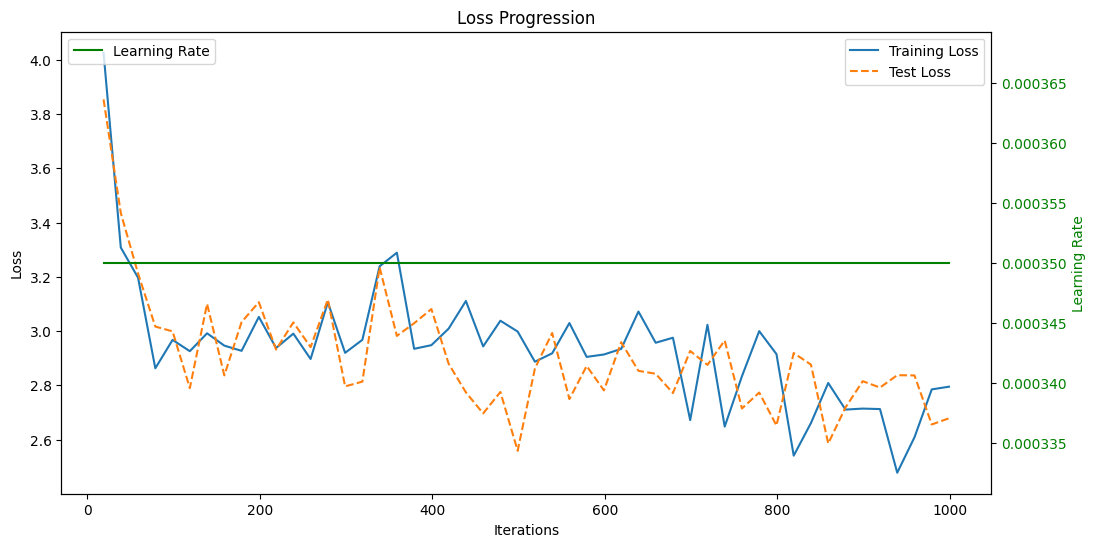

In [16]:
import matplotlib.pyplot as plt

# Create the figure and the primary y-axis
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))

# Plot the loss on the primary y-axis
ax1.plot(epoch_count, train_loss_values, label='Training Loss')
ax1.plot(epoch_count, test_loss_values, label='Test Loss', linestyle='--')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Progression')

# Create the secondary y-axis for the learning rate
ax2 = ax1.twinx()
ax2.plot(epoch_count, learning_rates, label='Learning Rate', color='green')
ax2.set_ylabel('Learning Rate', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add legends to each y-axis
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')

# Show the plot
plt.show()

In [ ]:
import nltk

def translate(sentence, max_output_length=20):
    tokens = nltk.word_tokenize(sentence)
    tokens, _ = model.evaluate(tokens, max_output_length)
    return ' '.join(tokens)

In [18]:
### Use model ###

print(translate('Go!'))
print(translate('It\'s not Fine.'))
print(translate('I\'m very happy today.'))
print(translate('He\'s very sad.'))
print(translate('That man is wearing a white shirt.'))
print(translate('He\'s very afraid of spiders.'))
print(translate('He\'s going home to his wife.'))
print(translate('Those guys are walking to work.'))
print(translate('I\'m not going with you today.'))
print(translate('My girlfriend will not come over tomorrow.'))
print(translate('He bought his friends a present for christmas.'))


<sos> Ik . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<sos> Je is het . . <eos>
<sos> Ik ben . <eos>
<sos> Je is je . <eos>
<sos> Het is <unk> <unk> . <eos>
<sos> Je is niet . <eos>
<sos> Je is je . . <eos>
<sos> En , , , . <eos>
<sos> Ik ben ik . <eos>
<sos> <unk> , , . <eos>
<sos> Het is een <unk> <unk> <unk> . <eos>


In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def evaluateAndShowAttention():

    ''' Sample a random sentence from the test data '''
    input_tokens = test_data.sample()['ENG_TOKENS'].iloc[0]

    output_tokens, attentions = model.evaluate(input_tokens)

    output_tokens = output_tokens[1:] # Remove single batch dimension

    attentions = attentions.cpu().numpy()
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='plasma')
    fig.colorbar(cax)
                       
    # Set up axes
    ax.set_xticks(range(len(input_tokens)))
    ax.set_yticks(range(len(output_tokens)))

    ax.set_xticklabels(input_tokens, rotation=90)
    ax.set_yticklabels(output_tokens)

    plt.show()

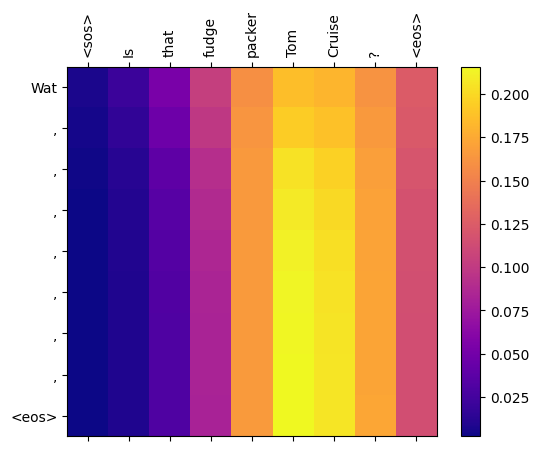

In [20]:
evaluateAndShowAttention()